# 动量法
使用梯度下降法，每次都会朝着目标函数下降最快的方向，这也称为最速下降法。这种更新方法看似非常快，实际上存在一些问题。

## 梯度下降法的问题
考虑一个二维输入，$[x_1, x_2]$，输出的损失函数 $L: R^2 \rightarrow R$，下面是这个函数的等高线

![](https://ws1.sinaimg.cn/large/006tKfTcly1fmnketw5f4j30az04lq31.jpg)

可以想象成一个很扁的漏斗，这样在竖直方向上，梯度就非常大，在水平方向上，梯度就相对较小，所以我们在设置学习率的时候就不能设置太大，为了防止竖直方向上参数更新太过了，这样一个较小的学习率又导致了水平方向上参数在更新的时候太过于缓慢，所以就导致最终收敛起来非常慢。

## 动量法
动量法的提出就是为了应对这个问题，我们梯度下降法做一个修改如下

$$
v_i = \gamma v_{i-1} + \eta \nabla L(\theta)
$$
$$
\theta_i = \theta_{i-1} - v_i
$$

其中 $v_i$ 是当前速度，$\gamma$ 是动量参数，是一个小于 1的正数，$\eta$ 是学习率

相当于每次在进行参数更新的时候，都会将之前的速度考虑进来，每个参数在各方向上的移动幅度不仅取决于当前的梯度，还取决于过去各个梯度在各个方向上是否一致，如果一个梯度一直沿着当前方向进行更新，那么每次更新的幅度就越来越大，如果一个梯度在一个方向上不断变化，那么其更新幅度就会被衰减，这样我们就可以使用一个较大的学习率，使得收敛更快，同时梯度比较大的方向就会因为动量的关系每次更新的幅度减少，如下图

![](https://ws1.sinaimg.cn/large/006tNc79gy1fmo5l53o76j30ak04gjrh.jpg)

比如我们的梯度每次都等于 g，而且方向都相同，那么动量法在该方向上使参数加速移动，有下面的公式：

$$
v_0 = 0
$$
$$
v_1 = \gamma v_0 + \eta g = \eta g
$$
$$
v_2 = \gamma v_1 + \eta g = (1 + \gamma) \eta g
$$
$$
v_3 = \gamma v_2 + \eta g = (1 + \gamma + \gamma^2) \eta g
$$
$$
\cdots
$$
$$
v_{+ \infty} = (1 + \gamma + \gamma^2 + \gamma^3 + \cdots) \eta g = \frac{1}{1 - \gamma} \eta g
$$

如果我们把 $\gamma$ 定为 0.9，那么更新幅度的峰值就是原本梯度乘学习率的 10 倍。

本质上说，动量法就仿佛我们从高坡上推一个球，小球在向下滚动的过程中积累了动量，在途中也会变得越来越快，最后会达到一个峰值，对应于我们的算法中就是，动量项会沿着梯度指向方向相同的方向不断增大，对于梯度方向改变的方向逐渐减小，得到了更快的收敛速度以及更小的震荡。

下面我们手动实现一个动量法，公式已经在上面了

In [1]:
def sgd_momentum(parameters, vs, lr, gamma):
    for param, v in zip(parameters, vs):
        v[:] = gamma * v + lr * param.grad.data
        param.data = param.data - v

In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('~/Documents/pytorch/DeepLearning/mnist', train=True, transform=data_tf) # 载入数据集，申明定义的数据变换
test_set = MNIST('~/Documents/pytorch/DeepLearning/mnist', train=False, transform=data_tf)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [3]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 将速度初始化为和参数形状相同的零张量
vs = []
for param in net.parameters():
    vs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_momentum(net.parameters(), vs, 1e-2, 0.9) # 使用的动量参数为 0.9，学习率 0.01
        # 记录误差
        train_loss += loss.item()
        
        losses.append(loss.item())
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.365094
epoch: 1, Train Loss: 0.172423
epoch: 2, Train Loss: 0.126380
epoch: 3, Train Loss: 0.102769
epoch: 4, Train Loss: 0.084595
使用时间: 32.97664 s


可以看到，加完动量之后 loss 能下降非常快，但是一定要小心学习率和动量参数，这两个值会直接影响到参数每次更新的幅度，所以可以多试几个值

当然，pytorch 内置了动量法的实现，非常简单，直接在 `torch.optim.SGD(momentum=0.9)` 即可，下面实现一下

In [6]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # 加动量
# 开始训练
losses = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0: # 30 步记录一次
            losses.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.370345
epoch: 1, Train Loss: 0.175626
epoch: 2, Train Loss: 0.129088
epoch: 3, Train Loss: 0.102106
epoch: 4, Train Loss: 0.087477
使用时间: 30.70829 s


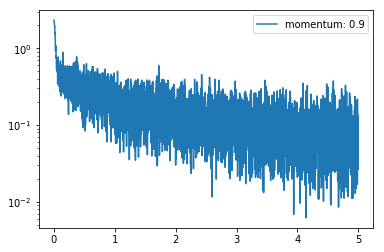

In [11]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='momentum: 0.9')
plt.legend(loc='best')

我们可以对比一下不加动量的随机梯度下降法

In [13]:
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2) # 不加动量
# 开始训练
losses1 = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0: # 30 步记录一次
            losses1.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.736683
epoch: 1, Train Loss: 0.363961
epoch: 2, Train Loss: 0.318637
epoch: 3, Train Loss: 0.291822
epoch: 4, Train Loss: 0.270264
使用时间: 28.00842 s


In [15]:
len(losses)

4690

In [16]:
len(losses1)

157

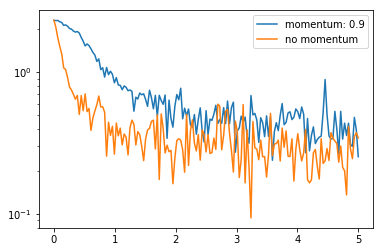

In [18]:
x_axis = np.linspace(0, 5, 157, endpoint=True)
plt.semilogy(x_axis, losses[:157], label='momentum: 0.9')
plt.semilogy(x_axis, losses1, label='no momentum')
plt.legend(loc='best')

可以看到加完动量之后的 loss 下降的程度更低了，可以将动量理解为一种惯性作用，所以每次更新的幅度都会比不加动量的情况更多